# Tutorial 9: Learning Rate Controller
___
In this tutorial, we are going to show you how to use a specific Trace - `LRController` to __change your learning rate during the training__.  In general, `LRController` takes care of both learning rate scheduling as well as changing learning rate on validation.

If you are a keras user, you can see `LRController` as a combination of LRScheduler and ReduceLROnPlateau.

In [1]:
import numpy as np
import tensorflow as tf
import fastestimator as fe
import matplotlib.pyplot as plt

## Step 0- Preparation

In [2]:
from fastestimator.architecture import LeNet
from fastestimator.op.tensorop.model import ModelOp
from fastestimator.op.tensorop.loss import SparseCategoricalCrossentropy
from fastestimator.op.tensorop import Minmax

# Create a function to get Pipeline and Network
def get_pipeline_network():
    # step 1. Prepare data
    (x_train, y_train), (x_eval, y_eval) = tf.keras.datasets.mnist.load_data()
    train_data = {"x": np.expand_dims(x_train, -1), "y": y_train}
    eval_data = {"x": np.expand_dims(x_eval, -1), "y": y_eval}
    data = {"train": train_data, "eval": eval_data}
    pipeline = fe.Pipeline(batch_size=32, data=data, ops=Minmax(inputs="x", outputs="x"))

    # step 2. Prepare model
    model = fe.build(model_def=LeNet, model_name="lenet", optimizer="adam", loss_name="my_loss")
    network = fe.Network(ops=[ModelOp(inputs="x", model=model, outputs="y_pred"), 
                              SparseCategoricalCrossentropy(inputs=("y", "y_pred"), outputs="my_loss")])
    return pipeline, network

## Option 1- Customize the learning rate: step-wise control

Let's define our learning rate scheduler to be 0.001 * (1 + step // 500).

In [3]:
from fastestimator.trace import LRController
from fastestimator.schedule import LRSchedule

# Create a LR Scheduler with a custom schedule_fn
class MyLRSchedule1(LRSchedule):
    def schedule_fn(self, current_step_or_epoch, lr):
        lr = 0.001 * (1 + current_step_or_epoch // 500)
        return lr

# Create pipeline, network and lr_scheduler
pipeline1, network1 = get_pipeline_network()
lr_scheduler1 = MyLRSchedule1(schedule_mode="step") # we want to change the lr at a step level

# In Estimator, indicate in traces the LR Scheduler using LR Controller, you also have to specify the model_name.
estimator1 = fe.Estimator(pipeline=pipeline1, 
                         network=network1, 
                         epochs=2,
                         traces=LRController(model_name="lenet", lr_schedule=lr_scheduler1))

In [4]:
# Save the training history and train the model
history1 = estimator1.fit(summary="custom_lr_scheduler_step")

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 0; total_train_steps: 3750; lenet_lr: 0.001; 
FastEstimator-Train: step: 0; my_loss: 2.3263931; lenet_lr: 0.001; 
FastEstimator-Train: step: 100; my_loss: 0.537272; examples/sec: 1985.7; progress: 2.7%; lenet_lr: 0.001; 
FastEstimator-Train: step: 200; my_loss: 0.3569404; examples/sec: 1984.7; progress: 5.3%; lenet_lr: 0.001; 
FastEstimator-Train: step: 300; my_loss: 0.1743724; examples/sec: 1980.0; progress: 8.0%; lenet_lr: 0.001; 
FastEstimator-Train: 

We will use visualize_logs to plot the learning rate. We only want to display this metric, so we specify it in include_metrics.

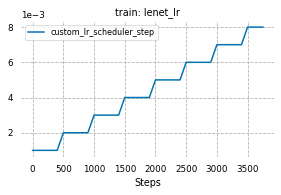

In [5]:
from fastestimator.summary import visualize_logs

# Show the learning rates history for each step
visualize_logs(history1, include_metrics="lenet_lr")

## Option 2 - Customize the learning rate: epoch-wise control

Let's now define learning rate to be (epoch +1 ) * 0.002. The only change will be in schedule_mode.

In [6]:
from fastestimator.trace import LRController
from fastestimator.schedule import LRSchedule

# We define our custom Scheduler in the same way as above.
class MyLRSchedule2(LRSchedule):
    def schedule_fn(self, current_step_or_epoch, lr):
        lr = 0.002 * (1 + current_step_or_epoch)
        return lr

# Create pipeline and network.
pipeline2, network2 = get_pipeline_network()

# Here we now indicate epoch as schedule_mode.
lr_scheduler2 = MyLRSchedule2(schedule_mode="epoch")
estimator2 = fe.Estimator(pipeline=pipeline2, 
                         network=network2, 
                         epochs=2,
                         traces=LRController(model_name="lenet", lr_schedule=lr_scheduler2))

In [7]:
# Train and save history
history2 = estimator2.fit(summary="custom_lr_scheduler_epoch")

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 0; total_train_steps: 3750; lenet_lr: 0.001; 
FastEstimator-Train: step: 0; my_loss: 2.2759442; lenet_lr: 0.002; 
FastEstimator-Train: step: 100; my_loss: 0.1299229; examples/sec: 2057.3; progress: 2.7%; lenet_lr: 0.002; 
FastEstimator-Train: step: 200; my_loss: 0.1066295; examples/sec: 2031.6; progress: 5.3%; lenet_lr: 0.002; 
FastEstimator-Train: step: 300; my_loss: 0.0411298; examples/sec: 2032.4; progress: 8.0%; lenet_lr: 0.002; 
FastEstimator-Train:

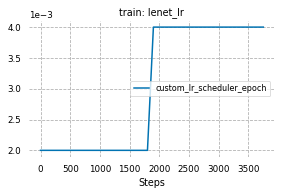

In [8]:
# Show the learning rate for each step: it changes only at an epoch level!
visualize_logs(history2, include_metrics="lenet_lr")

## Option 3- Built-in Cyclic Learning Rate - example 1

FastEstimator provides many pre-implemented popular learning rate shedulers for users. 
Here, we are going to use `CyclicLRSchedule`: it is a generalization of many learning rate schedulers.

In the next example, let's decay the learning rate by half of cosine curve.

In [9]:
from fastestimator.trace import LRController
from fastestimator.schedule import CyclicLRSchedule

# Create pipeline and network
pipeline3, network3 = get_pipeline_network()

# Directly use the pre-built CyclicLRSchedule, with a cosine decrease method and one cycle.
estimator3 = fe.Estimator(pipeline=pipeline3, 
                         network=network3, 
                         epochs=2,
                         traces=LRController(model_name="lenet", 
                                             lr_schedule=CyclicLRSchedule(num_cycle=1, decrease_method="cosine")))

In [10]:
# Train and save history
history3 = estimator3.fit(summary="cyclic_1")

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 0; total_train_steps: 3750; lenet_lr: 0.001; 
FastEstimator-Train: step: 0; my_loss: 2.3072138; lenet_lr: 0.001; 
FastEstimator-Train: step: 100; my_loss: 0.649567; examples/sec: 1976.5; progress: 2.7%; lenet_lr: 0.000998; 
FastEstimator-Train: step: 200; my_loss: 0.3672558; examples/sec: 1956.0; progress: 5.3%; lenet_lr: 0.000993; 
FastEstimator-Train: step: 300; my_loss: 0.2800382; examples/sec: 1925.8; progress: 8.0%; lenet_lr: 0.000984; 
FastEstimato

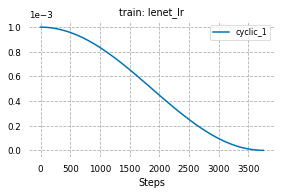

In [11]:
# Plot the learning rate for each step
visualize_logs(history3, include_metrics="lenet_lr")

## Option 3- Built-in Cyclic Learning Rate: example 2

Users can also choose to add more cycles of the learning rate with `num_cycle`, and to change the subsequent cycle length using `cycle_multiplier`. If `cycle_multiplier=2`, the second cycle will be twice as long as the first one.

In [12]:
from fastestimator.trace import LRController
from fastestimator.schedule import CyclicLRSchedule

# We create pipeline and network.
pipeline4, network4 = get_pipeline_network()

# We specify num_cycle and cycle_multiplier in CyclicLRSchedule.
estimator4 = fe.Estimator(pipeline=pipeline4, 
                         network=network4, 
                         epochs=2,
                         traces=LRController(model_name="lenet", 
                                             lr_schedule=CyclicLRSchedule(num_cycle=2, 
                                                                          cycle_multiplier=2, 
                                                                          decrease_method="cosine")))

In [13]:
# Train and save history
history4 = estimator4.fit(summary="cyclic_2")

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 0; total_train_steps: 3750; lenet_lr: 0.001; 
FastEstimator-Train: step: 0; my_loss: 2.307187; lenet_lr: 0.001; 
FastEstimator-Train: step: 100; my_loss: 0.2040534; examples/sec: 1925.7; progress: 2.7%; lenet_lr: 0.000984; 
FastEstimator-Train: step: 200; my_loss: 0.0947927; examples/sec: 1941.5; progress: 5.3%; lenet_lr: 0.000938; 
FastEstimator-Train: step: 300; my_loss: 0.1095315; examples/sec: 1915.9; progress: 8.0%; lenet_lr: 0.000865; 
FastEstimato

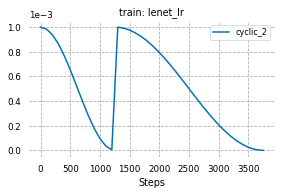

In [14]:
# Plot the learning rate
visualize_logs(history4, include_metrics="lenet_lr")

We observe that we have two cycles of decreasing learning rate, and the second one is twice as long as the first one.